In [27]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

import gudhi as gd
from gudhi.wasserstein import wasserstein_distance

from scipy.spatial import cKDTree
from itertools import combinations
from matplotlib.colors import TwoSlopeNorm
import time
from joblib import Parallel, delayed


In [28]:
# 3D data: full 3D point cloud
data_u = np.random.uniform(-1, 1, (1000, 3))
data_3d = data_u  # Use full 3D coordinates


In [29]:
## 3D version: 4-point correlation function (tetrahedra)
## Eliminate for loops, parallelize as much as possible


In [30]:
def _oriented_tet_volume_signs(center, r1, r2, r3):
    """Compute oriented volume signs for tetrahedra (3D chirality).
    Returns +1 for right-handed, -1 for left-handed, 0 for coplanar.
    Vectorized: works on arrays of tetrahedra."""
    cross = np.cross(r2, r3, axis=1)
    det = np.sum(r1 * cross, axis=1) / 6.0
    return np.sign(det)


In [31]:
def choose_eps_3d(st, fallback=0.15, mode="h2_mid", q=0.5, scale=1.0):
    """Auto-select epsilon from persistence diagrams (3D: includes H2)."""
    def _finite_np(dgm):
        d = np.array(dgm, dtype=float)
        if d.size == 0: return d.reshape(0,2)
        if d.ndim == 1: d = d.reshape(-1,2)
        return d[np.isfinite(d).all(axis=1)]
    try:
        d0 = st.persistence_intervals_in_dimension(0)
        d1 = st.persistence_intervals_in_dimension(1)
        d2 = st.persistence_intervals_in_dimension(2)
    except Exception:
        st.persistence(homology_coeff_field=2, min_persistence=0.0)
        d0 = st.persistence_intervals_in_dimension(0)
        d1 = st.persistence_intervals_in_dimension(1)
        d2 = st.persistence_intervals_in_dimension(2)
    dgm1 = _finite_np(d1)
    dgm2 = _finite_np(d2)
    eps = None
    if mode == "h2_mid" and dgm2.size:
        pers = dgm2[:,1] - dgm2[:,0]
        j = int(np.argmax(pers))
        eps = 0.5 * (float(dgm2[j,0]) + float(dgm2[j,1]))
    elif mode == "h1_mid" and dgm1.size:
        pers = dgm1[:,1] - dgm1[:,0]
        j = int(np.argmax(pers))
        eps = 0.5 * (float(dgm1[j,0]) + float(dgm1[j,1]))
    elif mode == "h2_quant" and dgm2.size:
        eps = float(np.quantile(dgm2[:,1], q))
    elif mode == "h1_quant" and dgm1.size:
        eps = float(np.quantile(dgm1[:,1], q))
    if eps is None or not np.isfinite(eps) or eps <= 0:
        eps = float(fallback)
    return float(scale * eps)


In [32]:
# Unified, parallelized pipeline for 3D topology
def prepare_topology_3d(data_3d, use_rips=False, rmax=0.25, eps=None, mode="h2_mid", q=0.5, scale=1.0, n_jobs=-1, backend="loky"):
    """
    High-performance pipeline for 3D topology computation.
    Returns dict with:
      - st, eps, edges, tris, tets
      - left_tets, right_tets (3D chirality)
      - st_L, st_R
      - L0, L1, L2, R0, R1, R2 (persistence intervals)
      - Finite-only versions (L0n, L1n, L2n, R0n, R1n, R2n)
    """
    # 1) Build simplex tree (max_dimension=3 for tetrahedra)
    if use_rips:
        r = gd.RipsComplex(points=data_3d, max_edge_length=rmax)
        st = r.create_simplex_tree(max_dimension=3)
    else:
        ac = gd.AlphaComplex(points=data_3d)
        st = ac.create_simplex_tree()

    # 2) Auto epsilon if needed
    if eps is None:
        eps = choose_eps_3d(st, fallback=float(rmax), mode=mode, q=q, scale=scale)

    # 3) Extract simplices at eps (parallel classification)
    skeleton_data = list(st.get_skeleton(3))
    if not skeleton_data:
        return {
            "st": st, "eps": float(eps),
            "edges": [], "tris": [], "tets": [],
            "left_tets": [], "right_tets": [],
            "st_L": gd.SimplexTree(), "st_R": gd.SimplexTree(),
            "L0": [], "L1": [], "L2": [], "R0": [], "R1": [], "R2": [],
            "L0n": [], "L1n": [], "L2n": [], "R0n": [], "R1n": [], "R2n": [],
        }

    simplices, filtrations = [], []
    for s, f in skeleton_data:
        simplices.append(s)
        filtrations.append(f)
    filtrations = np.asarray(filtrations)
    valid_mask = filtrations <= eps
    if not np.any(valid_mask):
        return {
            "st": st, "eps": float(eps),
            "edges": [], "tris": [], "tets": [],
            "left_tets": [], "right_tets": [],
            "st_L": gd.SimplexTree(), "st_R": gd.SimplexTree(),
            "L0": [], "L1": [], "L2": [], "R0": [], "R1": [], "R2": [],
            "L0n": [], "L1n": [], "L2n": [], "R0n": [], "R1n": [], "R2n": [],
        }

    valid_simplices = [simplices[i] for i in range(len(simplices)) if valid_mask[i]]

    def _classify(s):
        L = len(s)
        if L == 2:
            i, j = tuple(s)
            if i > j: i, j = j, i
            return ("e", (int(i), int(j)))
        if L == 3:
            i, j, k = tuple(s)
            return ("t", (int(i), int(j), int(k)))
        if L == 4:
            i, j, k, l = tuple(s)
            return ("tet", (int(i), int(j), int(k), int(l)))
        return (None, None)

    results = Parallel(n_jobs=n_jobs, backend=backend, prefer="processes")(delayed(_classify)(s) for s in valid_simplices)
    edges = [v for t, v in results if t == "e"]
    tris  = [v for t, v in results if t == "t"]
    tets  = [v for t, v in results if t == "tet"]
    if edges:
        edges = sorted(edges)

    # 4) Split tetrahedra by 3D chirality (vectorized)
    if len(tets) == 0:
        left_tets, right_tets = [], []
    else:
        tets_arr = np.asarray(tets, dtype=int)
        center = data_3d[tets_arr[:,0]]  # Use first vertex as reference
        r1 = data_3d[tets_arr[:,1]] - center
        r2 = data_3d[tets_arr[:,2]] - center
        r3 = data_3d[tets_arr[:,3]] - center
        signs = _oriented_tet_volume_signs(center, r1, r2, r3)
        left_tets  = tets_arr[signs < 0]
        right_tets = tets_arr[signs > 0]

    # 5) Build Left/Right simplex trees
    st_L, st_R = gd.SimplexTree(), gd.SimplexTree()
    for s, f in st.get_skeleton(2):  # vertices, edges, triangles
        st_L.insert(s, filtration=float(f))
        st_R.insert(s, filtration=float(f))
    tet_filts = {frozenset(s): float(f) for s, f in skeleton_data if len(s) == 4}
    for t in left_tets:
        st_L.insert(tuple(t), filtration=tet_filts.get(frozenset(t), float(eps)))
    for t in right_tets:
        st_R.insert(tuple(t), filtration=tet_filts.get(frozenset(t), float(eps)))
    st_L.initialize_filtration(); st_R.initialize_filtration()

    # 6) Persistence and diagrams (including H2)
    st_L.persistence(homology_coeff_field=2, min_persistence=0.0)
    st_R.persistence(homology_coeff_field=2, min_persistence=0.0)
    L0 = st_L.persistence_intervals_in_dimension(0)
    L1 = st_L.persistence_intervals_in_dimension(1)
    L2 = st_L.persistence_intervals_in_dimension(2)
    R0 = st_R.persistence_intervals_in_dimension(0)
    R1 = st_R.persistence_intervals_in_dimension(1)
    R2 = st_R.persistence_intervals_in_dimension(2)

    def _finite_np(diag):
        d = np.array(diag, dtype=float)
        if d.size == 0: return d.reshape(0,2)
        if d.ndim == 1: d = d.reshape(-1,2)
        return d[np.isfinite(d).all(axis=1)]

    L0n, L1n, L2n = _finite_np(L0), _finite_np(L1), _finite_np(L2)
    R0n, R1n, R2n = _finite_np(R0), _finite_np(R1), _finite_np(R2)

    return {
        "st": st, "eps": float(eps),
        "edges": edges, "tris": tris, "tets": tets,
        "left_tets": left_tets.tolist() if isinstance(left_tets, np.ndarray) else left_tets,
        "right_tets": right_tets.tolist() if isinstance(right_tets, np.ndarray) else right_tets,
        "st_L": st_L, "st_R": st_R,
        "L0": L0, "L1": L1, "L2": L2, "R0": R0, "R1": R1, "R2": R2,
        "L0n": L0n, "L1n": L1n, "L2n": L2n, "R0n": R0n, "R1n": R1n, "R2n": R2n,
    }


In [33]:
# Test the unified 3D pipeline
res_3d = prepare_topology_3d(data_3d, use_rips=False, rmax=0.25, eps=None, mode="h2_mid", n_jobs=-1)
print(f"3D Pipeline Results:")
print(f"  eps={res_3d['eps']:.5g}")
print(f"  edges={len(res_3d['edges'])}, tris={len(res_3d['tris'])}, tets={len(res_3d['tets'])}")
print(f"  left_tets={len(res_3d['left_tets'])}, right_tets={len(res_3d['right_tets'])}")
print(f"  L2={len(res_3d['L2'])}, R2={len(res_3d['R2'])}")


3D Pipeline Results:
  eps=0.073974
  edges=6746, tris=11065, tets=5316
  left_tets=2697, right_tets=2619
  L2=4263, R2=4336


<ipython-input-32-19c54423e735>:98: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  st_L.initialize_filtration(); st_R.initialize_filtration()


In [34]:
def plot_pd_gudhi_split_3d(L1, L2, R1, R2, fname_prefix="pd_left_right_3d", title_prefix="Persistence diagram"):
    """
    Plot separate images for Left and Right complexes in 3D, each showing H1 and H2.
    """
    def _finite_np(dgm):
        d = np.array(dgm, dtype=float)
        if d.size == 0: return d.reshape(0,2)
        if d.ndim == 1: d = d.reshape(-1,2)
        return d[np.isfinite(d).all(axis=1)]

    L1f, L2f = _finite_np(L1), _finite_np(L2)
    R1f, R2f = _finite_np(R1), _finite_np(R2)

    def _lim(*arrs):
        mx = 0.0
        for a in arrs:
            if a.size:
                mx = max(mx, float(a.max()))
        return (mx*1.02) if mx > 0 and np.isfinite(mx) else 1.0

    lim = _lim(L1f, L2f, R1f, R2f)

    def _plot_single(ax, d1, d2, label, lim):
        xs = np.linspace(0.0, lim, 200)
        ax.plot(xs, xs, color="k", linewidth=1)
        ax.fill_between(xs, xs, lim, color="0.7", alpha=0.25)
        if d1.size:
            ax.scatter(d1[:,0], d1[:,1], s=20, alpha=0.9, label=f"{label} H1", color="red", edgecolors="none")
        if d2.size:
            ax.scatter(d2[:,0], d2[:,1], s=20, alpha=0.9, label=f"{label} H2", color="C0", edgecolors="none")
        ax.set_xlim(0, lim); ax.set_ylim(0, lim)
        ax.set_xlabel("Birth"); ax.set_ylabel("Death")
        ax.set_title(f"{title_prefix} — {label}")
        ax.legend(title="Dimension", loc="lower right")

    fig, axes = plt.subplots(1, 2, figsize=(9,4))
    _plot_single(axes[0], L1f, L2f, "Left", lim)
    _plot_single(axes[1], R1f, R2f, "Right", lim)
    plt.tight_layout()
    plt.savefig(f"{fname_prefix}_left_right.png", dpi=160)
    plt.show()
    print("Saved", f"{fname_prefix}_left_right.png")


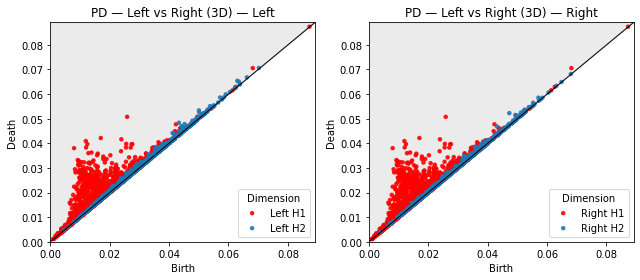

Saved pd_left_right_3d_left_right.png


In [35]:
# Plot 3D left vs right persistence diagrams
try:
    L1, L2, R1, R2
except NameError:
    L1, L2, R1, R2 = res_3d["L1"], res_3d["L2"], res_3d["R1"], res_3d["R2"]

plot_pd_gudhi_split_3d(L1, L2, R1, R2, fname_prefix="pd_left_right_3d", title_prefix="PD — Left vs Right (3D)")


In [36]:
def auto_plot_chirality_3d(data_3d, chirality="left", use_rips=False, rmax=0.25, eps=None, mode="h2_mid", q=0.5, scale=1.0, n_jobs=-1, backend="loky", title_prefix="3D complex", out=None, alpha=0.25):
    """
    Combined pipeline for 3D: build complex, auto-eps, extract, split by chirality, plot.
    chirality="left" or "right" (3D oriented volume sign).
    """
    # Run pipeline
    res = prepare_topology_3d(data_3d, use_rips=use_rips, rmax=rmax, eps=eps, mode=mode, q=q, scale=scale, n_jobs=n_jobs, backend=backend)
    
    chosen = np.asarray(res["left_tets"] if chirality == "left" else res["right_tets"], dtype=int)
    color = "C0" if chirality == "left" else "crimson"
    label = "Left-handed" if chirality == "left" else "Right-handed"

    # 3D plot with Poly3DCollection
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot edges (optional, can be heavy)
    # Plot tetrahedra as faces
    if len(chosen) > 0:
        # Extract faces of tetrahedra (4 faces per tetrahedron)
        faces = []
        for tet in chosen:
            i, j, k, l = tet
            # 4 faces: (i,j,k), (i,j,l), (i,k,l), (j,k,l)
            faces.append([data_3d[i], data_3d[j], data_3d[k]])
            faces.append([data_3d[i], data_3d[j], data_3d[l]])
            faces.append([data_3d[i], data_3d[k], data_3d[l]])
            faces.append([data_3d[j], data_3d[k], data_3d[l]])
        pc = Poly3DCollection(faces, alpha=alpha, facecolor=color, edgecolors="none")
        ax.add_collection3d(pc)

    ax.scatter(data_3d[:,0], data_3d[:,1], data_3d[:,2], s=6, color="k", alpha=0.7)
    ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
    ax.set_title(f"{title_prefix} — {label} (#{len(chosen)})")
    plt.tight_layout()
    if out:
        plt.savefig(out, dpi=160)
    plt.show()

    return res


<ipython-input-32-19c54423e735>:98: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  st_L.initialize_filtration(); st_R.initialize_filtration()


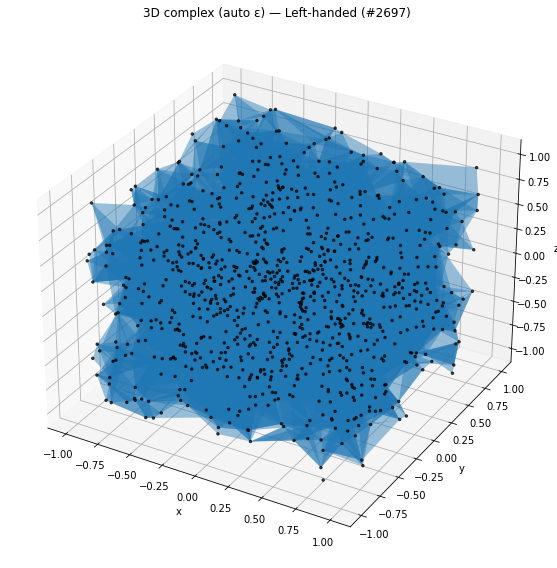

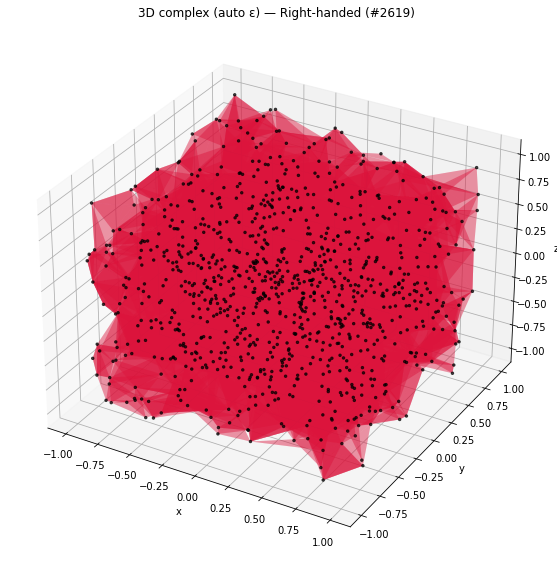

In [37]:
# Plot 3D chirality
res_left_3d = auto_plot_chirality_3d(data_3d, chirality="left", use_rips=False, rmax=0.25, n_jobs=-1, title_prefix="3D complex (auto ε)")
res_right_3d = auto_plot_chirality_3d(data_3d, chirality="right", use_rips=False, rmax=0.25, n_jobs=-1, title_prefix="3D complex (auto ε)")


In [38]:
import numpy as np
from gudhi.wasserstein import wasserstein_distance

def subtract_diagrams_combined_3d(dgmL, dgmR, order=1, internal_p=1, tol_decimals=None):
    """
    Combined, vectorized routine for 3D persistence diagrams.
    Same as 2D version but adapted for H1/H2 diagrams.
    """
    def _finite_np(dgm):
        d = np.array(dgm, dtype=float)
        if d.size == 0:
            return d.reshape(0, 2)
        if d.ndim == 1:
            d = d.reshape(-1, 2)
        m = np.isfinite(d).all(axis=1)
        return d[m]

    L = _finite_np(dgmL)
    R = _finite_np(dgmR)

    out = {"L_finite": L, "R_finite": R}

    if tol_decimals is not None:
        if L.size:
            Lr = np.round(L, tol_decimals)
        else:
            Lr = L
        if R.size:
            Rr = np.round(R, tol_decimals)
        else:
            Rr = R
        def _as_struct(a):
            if a.size == 0:
                return a.view([("b", float), ("d", float)])
            return a.view([("b", a.dtype), ("d", a.dtype)]).reshape(-1)
        Ls = _as_struct(Lr)
        Rs = _as_struct(Rr)
        L_only_struct = np.setdiff1d(Ls, Rs, assume_unique=False)
        R_only_struct = np.setdiff1d(Rs, Ls, assume_unique=False)
        L_only = L_only_struct.view(Lr.dtype).reshape(-1, 2) if L_only_struct.size else np.zeros((0,2))
        R_only = R_only_struct.view(Rr.dtype).reshape(-1, 2) if R_only_struct.size else np.zeros((0,2))
        out.update({"L_only_set": L_only, "R_only_set": R_only})

    # ============================================================================
    # WASSERSTEIN SUBTRACTION SECTION (same as 2D version)
    # ============================================================================
    if L.size == 0 and R.size == 0:
        out.update({
            "W": 0.0,
            "pairs": [],
            "L_unmatched": np.zeros((0,2)),
            "R_unmatched": np.zeros((0,2)),
        })
        return out

    # STEP 1: Compute Wasserstein distance and get optimal matching
    W, matching = wasserstein_distance(L, R, order=order, internal_p=internal_p, matching=True)
    matching = np.asarray(matching, dtype=int)
    
    # STEP 2: Extract matching indices
    i_idx = matching[:,0]
    j_idx = matching[:,1]
    
    # STEP 3: Categorize matches
    both = (i_idx >= 0) & (j_idx >= 0)
    l_only = (i_idx >= 0) & (j_idx == -1)
    r_only = (j_idx >= 0) & (i_idx == -1)

    # STEP 4: Compute subtraction deltas
    pairs = []
    if np.any(both):
        Li = L[i_idx[both]]
        Rj = R[j_idx[both]]
        deltas = Li - Rj
        pairs = np.column_stack([i_idx[both], j_idx[both], deltas[:,0], deltas[:,1]]).tolist()

    # STEP 5: Extract unmatched points
    L_unmatched = L[i_idx[l_only]] if np.any(l_only) else np.zeros((0,2))
    R_unmatched = R[j_idx[r_only]] if np.any(r_only) else np.zeros((0,2))

    out.update({
        "W": float(W),
        "pairs": pairs,
        "L_unmatched": L_unmatched,
        "R_unmatched": R_unmatched,
    })
    return out


In [39]:
# Run subtract_diagrams_combined_3d for H1 and H2
try:
    L1, L2, R1, R2
except NameError:
    L1, L2, R1, R2 = res_3d["L1"], res_3d["L2"], res_3d["R1"], res_3d["R2"]

# H1 comparison
res_H1_3d = subtract_diagrams_combined_3d(L1, R1, order=1, internal_p=1, tol_decimals=9)
print("H1 Results (3D):")
print(f"  Wasserstein W1 = {res_H1_3d['W']:.6g}")
print(f"  Matched pairs = {len(res_H1_3d['pairs'])}")
print(f"  L-only = {len(res_H1_3d['L_unmatched'])}, R-only = {len(res_H1_3d['R_unmatched'])}")

# H2 comparison
res_H2_3d = subtract_diagrams_combined_3d(L2, R2, order=1, internal_p=1, tol_decimals=9)
print("\nH2 Results (3D):")
print(f"  Wasserstein W1 = {res_H2_3d['W']:.6g}")
print(f"  Matched pairs = {len(res_H2_3d['pairs'])}")
print(f"  L-only = {len(res_H2_3d['L_unmatched'])}, R-only = {len(res_H2_3d['R_unmatched'])}")

delta_H2 = np.array([[db, dd] for (_, _, db, dd) in res_H2_3d["pairs"]], dtype=float) if res_H2_3d["pairs"] else np.zeros((0,2))
print(f"\nDelta H2 (birth, death differences): shape {delta_H2.shape}")


H1 Results (3D):
  Wasserstein W1 = 0
  Matched pairs = 2474
  L-only = 0, R-only = 0

H2 Results (3D):
  Wasserstein W1 = 0.162539
  Matched pairs = 455
  L-only = 226, R-only = 211

Delta H2 (birth, death differences): shape (455, 2)
